# ECE421 Assignment 2: Neural Netorks
---
Name: Prerak Chaudhari  |  Student Number: 1005114760  |  Date: March 14, 2021

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

TensorFlow 1.x selected.
1.15.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def loadData():
    with np.load('/content/drive/MyDrive/ece421/assignments/a2/notMNIST.npz') as dataset:
        Data, Target = dataset["images"], dataset["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [4]:
# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [5]:
def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target

# Part 1: Logistic Regression with Numpy [20 points]

## Part 1.1: Helper Functions [6 points]

In [6]:
def relu(x):
    return x * (x > 0)

In [7]:
def softmax(x):
    x_i = np.exp(x - x.max())
    return x_i/np.sum(x_i , axis=1, keepdims=True)

In [8]:
def computeLayer(X, W, b):
    return np.matmul(X, W)+ b

In [9]:
def CE(target, prediction):
    loss = np.trace(np.multiply(target, np.log(prediction)))
    return -1*loss/target.shape[0]

In [10]:
def gradCE(target, prediction):
    return prediction - target

\begin{equation}
\begin{split}

\frac{\partial L}{\partial o_i} & = \frac{\partial}{\partial o_i}  (-\sum^K_{k=1} y_k \ln(p_k)) \\ 
& = - \frac{\partial}{\partial o_i}  (\sum^K_{k=1} y_k \ln(p_k)) \\ 
& = -[\frac{\partial}{\partial o_i} (y_i ln(p_i) + \sum^{}_{k \neq i} y_k \ln(p_k))] \\
& = -[\frac{\partial}{\partial o_i} (y_i ln(p_i)) + \frac{\partial}{\partial o_i} (\sum^{}_{k \neq i} y_k \ln(p_k))] \\
& = -[y_i \frac{\partial}{\partial p_i} (ln(p_i)) \frac{\partial p_i}{\partial o_i} + \sum^{}_{k \neq i} y_k \frac{\partial}{\partial p_k} (\ln(p_k))  \frac{\partial p_k}{\partial o_i}] \\
& = -[y_i \frac{1}{p_i} \frac{\partial}{\partial o_i} (\frac{e^{o_i}}{\sum^K_{j=1} e^{o_j}}) + \sum^{}_{k \neq i} y_k \frac{1}{p_k} \frac{\partial}{\partial o_i} (\frac{e^{o_k}}{\sum^K_{j=1} e^{o_j}})] \\
& = -[y_i \frac{1}{p_i} (\frac{(e^{o_i})(\sum^K_{j=1} e^{o_j}) - (e^{o_i})(e^{o_i})}{(\sum^K_{j=1} e^{o_j})^2}) + \sum^{}_{k \neq i} y_k \frac{1}{p_k} (\frac{(0)(\sum^K_{j=1} e^{o_j}) - (e^{o_k})(e^{o_i})}{(\sum^K_{j=1} e^{o_j})^2})] \\
& = -[y_i \frac{1}{p_i} (e^{o_i}) (\frac{(\sum^K_{j=1} e^{o_j}) - e^{o_i}}{(\sum^K_{j=1} e^{o_j})^2}) + \sum^{}_{k \neq i} y_k \frac{1}{p_k} (\frac{- (e^{o_k})(e^{o_i})}{(\sum^K_{j=1} e^{o_j})^2})] \\
& = -[y_i \frac{1}{p_i} \frac{e^{o_i}}{\sum^K_{j=1} e^{o_j}} (\frac{(\sum^K_{j=1} e^{o_j}) - e^{o_i}}{\sum^K_{j=1} e^{o_j}}) - \sum^{}_{k \neq i} y_k \frac{1}{p_k} (\frac{(e^{o_k})(e^{o_i})}{(\sum^K_{j=1} e^{o_j})^2})] \\
& = -[y_i \frac{1}{p_i} \frac{e^{o_i}}{\sum^K_{j=1} e^{o_j}} (1 - \frac{e^{o_i}}{\sum^K_{j=1} e^{o_j}}) - \sum^{}_{k \neq i} y_k \frac{1}{p_k} (\frac{e^{o_k}}{\sum^K_{j=1} e^{o_j}}) (\frac{e^{o_j}}{\sum^K_{j=1} e^{o_j}})] \\
& = -[y_i \frac{1}{p_i} p_i (1 - p_i) - \sum^{}_{k \neq i} y_k \frac{1}{p_k} p_k p_i] \\
& = -[y_i (1 - p_i) - \sum^{}_{k \neq i} y_k p_i] \\
& = -[y_i - y_i p_i - \sum^{}_{k \neq i} y_k p_i] \\
& = -[y_i - \sum^{K}_{k = 1} y_k p_i] \\
& = p_i \sum^{K}_{k = 1} y_k - y_i \\
& = p_i (1) - y_i \\
& = p_i - y_i \\

\end{split}
\end{equation}

\\

$$ \therefore \frac{\partial L}{\partial o} = p - y $$




## Part 1.2: Backpropagation Derivation [8 points]


1.

\begin{equation}
\begin{split}

\frac{\partial L}{\partial W_o} & = \frac{\partial L}{\partial o} \frac{\partial o}{\partial W_o} \\ 
& = (p - y) \frac{\partial}{\partial W_o} (x_h W_o + b_o) \\ 
& = x^T_h (p - y) \\ 

\end{split}
\end{equation}

In [11]:
def grad_W_o(target, p, x_h):
    return np.matmul(x_h.T, gradCE(target, p)) / target.shape[0]

2.

\begin{equation}
\begin{split}

\frac{\partial L}{\partial b_o} & = \frac{\partial L}{\partial o} \frac{\partial o}{\partial b_o} \\ 
& = (p - y) \frac{\partial}{\partial b_o} (x_h W_o + b_o) \\ 
& = \mathbf{1}^T (p - y) \\ 

\end{split}
\end{equation}

In [12]:
def grad_b_o(target, p):
    return np.sum(gradCE(target, p), axis=0) / target.shape[0]

3.

\begin{equation}
\begin{split}

\frac{\partial L}{\partial W_h} & = \frac{\partial L}{\partial o} \frac{\partial o}{\partial x_h} \frac{\partial x_h}{\partial s_h} \frac{\partial s_h}{\partial W_h} \\ 
& = (p - y) \frac{\partial}{\partial x_h} (x_h W_o + b_o) \frac{\partial}{\partial s_h} (ReLU(s_h)) \frac{\partial}{\partial W_h} (x_{in} W_h + b_{h})\\ 
& = x^T_{in} (p - y) W^T_o \mathbf{1}(x_h > 0)\\ 

\end{split}
\end{equation}

In [13]:
def grad_W_h(target, p, x_in, x_h, W_o):
    dL_xh = np.matmul(gradCE(target, p), W_o.T)
    dxh_sh = x_h.copy()
    dxh_sh [dxh_sh > 0] = 1
    dxh_sh [dxh_sh <= 0] = 0
    dL_sh = dL_xh * dxh_sh
    return np.dot(x_in.T, dL_sh) / target.shape[0]

4.

\begin{equation}
\begin{split}

\frac{\partial L}{\partial b_h} & = \frac{\partial L}{\partial o} \frac{\partial o}{\partial x_h} \frac{\partial x_h}{\partial s_h} \frac{\partial s_h}{\partial b_h} \\ 
& = (p - y) \frac{\partial}{\partial x_h} (x_h W_o + b_o) \frac{\partial}{\partial s_h} (ReLU(s_h)) \frac{\partial}{\partial b_h} (x_{in} W_h + b_h)\\ 
& = \mathbf{1}^T (p - y) W^T_o \mathbf{1}(x_h > 0)\\ 

\end{split}
\end{equation}

In [14]:
def grad_b_h(target, p, x_h, W_o):
    dL_xh = np.matmul(gradCE(target, p), W_o.T)
    dxh_sh = x_h.copy()
    dxh_sh [dxh_sh > 0] = 1
    dxh_sh [dxh_sh <= 0] = 0
    dL_sh = dL_xh * dxh_sh
    return np.sum(dL_sh, axis=0) / target.shape[0]

## Part 1.3: Learning [6 points]

In [15]:
def plot_curves(train_acc, train_loss, val_acc, val_loss, test_acc, test_loss, plot_test):
    n = len(train_acc)
    plt.figure(figsize=(20,10))
    plt.title("Model Loss Plot over Epochs")
    plt.plot(range(1,1+n), train_loss, label="Train")
    plt.plot(range(1,1+n), val_loss, label="Validation")
    if plot_test:
        plt.plot(range(1,1+n), test_loss, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Loss: {}".format(train_loss[-1]))
    print("Final Validation Loss: {}".format(val_loss[-1]))
    if plot_test:
        print("Final Testing Loss: {}".format(test_loss[-1]))

    plt.figure(figsize=(20,10))
    plt.title("Model Accuracy Plot over Epochs")
    plt.plot(range(1,1+n), train_acc, label="Train")
    plt.plot(range(1,1+n), val_acc, label="Validation")
    if plot_test:
        plt.plot(range(1,1+n), test_acc, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    if plot_test:
        print("Final Testing Accuracy: {}".format(test_acc[-1]))

In [16]:
def forward_pass (x_in, W_h, b_h, W_o, b_o):
    s_h = computeLayer(x_in, W_h, b_h)
    x_h = relu(s_h)
    o = computeLayer(x_h, W_o, b_o)
    p = softmax(o)

    return s_h, x_h, o, p

In [17]:
def backward_pass (x_in, s_h, x_h, o, p, target, W_h, b_h, W_o, b_o, vW_h, vb_h, vW_o, vb_o):
    vW_h = 0.99*vW_h + 0.1*grad_W_h(target, p, x_in, x_h, W_o)
    vb_h = 0.99*vb_h + 0.1*grad_b_h(target, p, x_h, W_o)
    vW_o = 0.99*vW_o + 0.1*grad_W_o(target, p, x_h)
    vb_o = 0.99*vb_o + 0.1*grad_b_o(target, p)

    W_h = W_h - vW_h
    b_h = b_h - vb_h
    W_o = W_o - vW_o
    b_o = b_o - vb_o

    return W_h, b_h, W_o, b_o, vW_h, vb_h, vW_o, vb_o

In [18]:
def initWeights (input_size, hidden_size, output_size):
    W_h = np.random.normal(0, (2/(input_size+hidden_size))**0.5, (input_size, hidden_size))
    b_h = np.zeros((1, hidden_size))
    W_o = np.random.normal(0, (2/(hidden_size+output_size))**0.5, (hidden_size, output_size))
    b_o = np.zeros((1, output_size))

    vW_h = 1e-5 * np.ones((input_size, hidden_size))
    vb_h = 1e-5 * np.ones((1, hidden_size))
    vW_o = 1e-5 * np.ones((hidden_size, output_size))
    vb_o = 1e-5 * np.ones((1, output_size))

    return W_h, b_h, W_o, b_o, vW_h, vb_h, vW_o, vb_o

In [19]:
H = 1000

trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

trainTarget, validTarget, testTarget = convertOneHot(trainTarget, validTarget, testTarget)

trainData = trainData.reshape(-1, 28*28)
validData = validData.reshape(-1, 28*28)
testData = testData.reshape(-1, 28*28)

W_h, b_h, W_o, b_o, vW_h, vb_h, vW_o, vb_o = initWeights(trainData.shape[1], H, 10)

train_accuracy, valid_accuracy, test_accuracy, train_loss, valid_loss, test_loss = [], [], [], [], [], []

epochs = 200

In [20]:
print ("Training Started...")
print("EPOCH NUMBER\tTRAINING ACCURACY\tTRAINING LOSS\t\tVALIDATION ACCURACY\tVALIDATION LOSS\t\tTESTING ACCURACY\tTESTING LOSS")

for epoch in range(epochs):
    # forward prop
    s_h, x_h, o, p = forward_pass(trainData, W_h, b_h, W_o, b_o)
    
    # backward prop
    W_h, b_h, W_o, b_o, vW_h, vb_h, vW_o, vb_o = backward_pass (trainData, s_h, x_h, o, p, trainTarget, W_h, b_h, W_o, b_o, vW_h, vb_h, vW_o, vb_o)
    
    # training accuracy and loss
    loss = CE(trainTarget, p)
    accuracy = np.sum(np.argmax(p, axis=1) == np.argmax(trainTarget, axis=1)) / trainTarget.shape[0]

    train_loss.append(loss)
    train_accuracy.append(accuracy)

    # validation accuracy and loss
    s_h, x_h, o, p = forward_pass(validData, W_h, b_h, W_o, b_o)

    loss = CE(validTarget, p)
    accuracy = np.sum(np.argmax(p, axis=1) == np.argmax(validTarget, axis=1)) / validTarget.shape[0]

    valid_loss.append(loss)
    valid_accuracy.append(accuracy)

    # testing accuracy and loss
    s_h, x_h, o, p = forward_pass(testData, W_h, b_h, W_o, b_o)

    loss = CE(testTarget, p)
    accuracy = np.sum(np.argmax(p, axis=1) == np.argmax(testTarget, axis=1)) / testTarget.shape[0]

    test_loss.append(loss)
    test_accuracy.append(accuracy)

    # show results
    print("%d \t\t %10.9f \t\t %10.7f \t\t %10.9f \t\t %10.7f \t\t %10.9f \t\t %10.7f" % (epoch, train_accuracy[-1], train_loss[-1], valid_accuracy[-1], valid_loss[-1], test_accuracy[-1], test_loss[-1]))

Training Started...
EPOCH NUMBER	TRAINING ACCURACY	TRAINING LOSS		VALIDATION ACCURACY	VALIDATION LOSS		TESTING ACCURACY	TESTING LOSS
0 		 0.090800000 		  0.0001746 		 0.296833333 		  0.0002527 		 0.299559471 		 -0.0000000
1 		 0.306400000 		  0.0002160 		 0.527166667 		  0.0002321 		 0.537077827 		 -0.0000000
2 		 0.532300000 		  0.0001633 		 0.708000000 		  0.0000536 		 0.731277533 		 -0.0000000
3 		 0.718000000 		  0.0000543 		 0.763500000 		  0.0000150 		 0.769823789 		 -0.0000000
4 		 0.765700000 		  0.0000378 		 0.811166667 		  0.0000034 		 0.813509545 		 -0.0000000
5 		 0.811100000 		  0.0000453 		 0.824000000 		  0.0000012 		 0.841042584 		 -0.0000000
6 		 0.829700000 		  0.0000185 		 0.812833333 		  0.0000021 		 0.832599119 		 -0.0000000
7 		 0.821300000 		  0.0000042 		 0.819833333 		  0.0000004 		 0.836270191 		 -0.0000000
8 		 0.827800000 		  0.0000018 		 0.850333333 		  0.0000000 		 0.864170338 		 -0.0000000
9 		 0.855100000 		  0.0000011 		 0.851000000 		  0.0000000 		 0.8

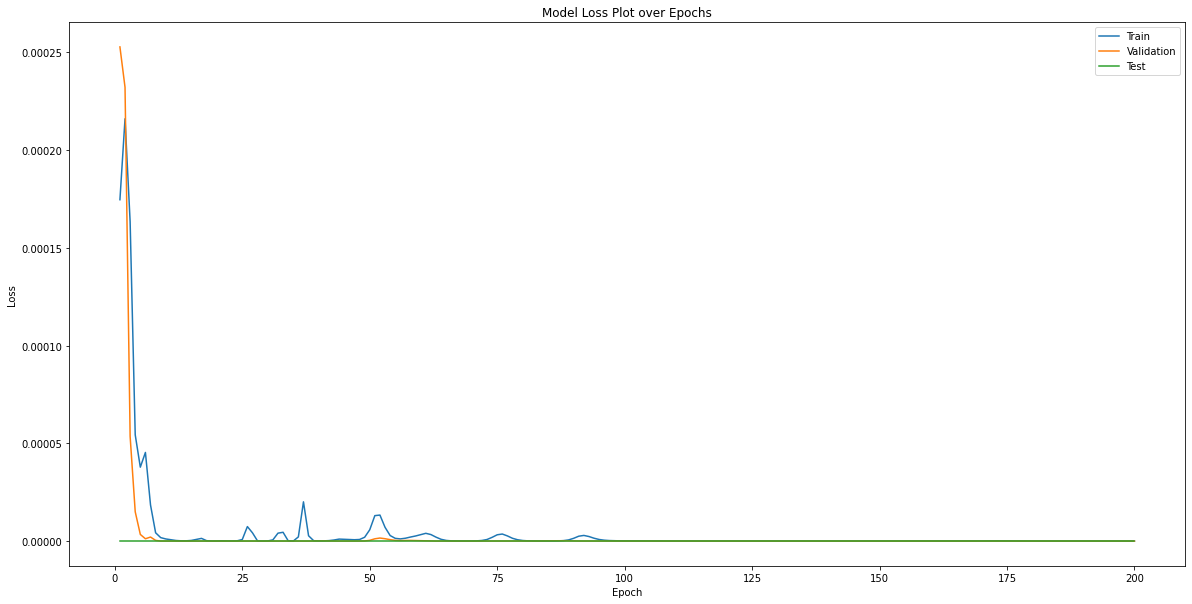

Final Training Loss: 1.6893800296777892e-10
Final Validation Loss: 7.938094626070058e-18
Final Testing Loss: -0.0


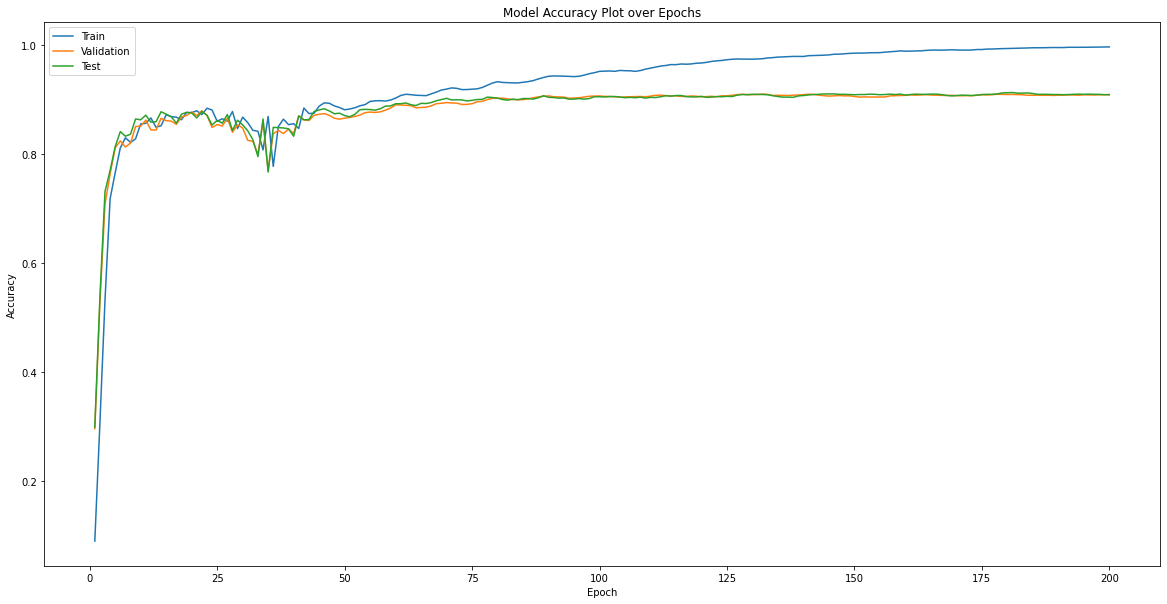

Final Training Accuracy: 0.9962
Final Validation Accuracy: 0.9083333333333333
Final Testing Accuracy: 0.908957415565345


In [21]:
plot_curves(train_accuracy, train_loss, valid_accuracy, valid_loss, test_accuracy, test_loss, 1)